# **Assignment 1: Kaggle_Salary**

*   **name**: Yaqi Zhang
*   **student number**: 1006584288

In [0]:
#Import all the necessory libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler as ss
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from imblearn.over_sampling import SMOTE

# **1. Data cleaning** 

In [83]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [84]:
os.chdir('/drive/My Drive/Colab Notebooks/1624 Assignment')
df = pd.read_csv('Kaggle_Salary.csv')
Salaries = pd.read_csv("multiple_choice_responses.csv", low_memory = False)
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (73,77,114,146,153,171,175,212,224,228,231) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,...,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"30,000-39,999",$0 (USD),Twitter (data science influencers),NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,NaN,NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,-1,NaN,Coursera,NaN,DataCamp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999"
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,-1,"5,000-7,499","> $100,000 ($USD)",NaN,NaN,NaN,"Kaggle (forums, blog, social media, etc)",NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)","Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",NaN,NaN,NaN,NaN,-1,NaN,Coursera,NaN,DataCamp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"250,000-299,999","$10,000-$99,999",NaN,NaN,NaN,NaN,NaN,NaN,"Podcasts (Chai Time Data Science, Linear Digre...","Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,"Slack Communities (ods.ai, kagglenoobs, etc)",NaN,NaN,-1,NaN,Coursera,edX,DataCamp,NaN,...,NaN,Azure Machine Learning Studio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1,14,">250,000"
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,No (we do not use ML methods),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"4,000-4,999",$0 (USD),NaN,NaN,NaN,NaN,NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)",NaN,"Blogs (Towards Data Science, Medium, Analytics...",NaN,NaN,NaN,Other,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,0,"0-9,999"
4,470,50-54,Male,-1,France,Master’s degree,Data Scientist,-1,0-49 employees,3-4,"We have well established ML methods (i.e., mod...",NaN,NaN,Build prototypes to explore applying machine l...,NaN,NaN,Do research that advances the state of the art...,NaN,NaN,-1,"60,000-69,999","$10,000-$99,999",NaN,NaN,NaN,NaN,NaN,"YouTube (Cloud AI Adventures, Siraj Raval, etc)",NaN,"Blogs (Towards Data Science, Medium, Analytics...",Journal Publications (traditional publications...,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,RapidMiner,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,Auto-Keras,NaN,NaN,NaN,Na

In [85]:
#Prints out all the questions to find how to do the data cleaning based on what kind of questions are asked.
a = Salaries.columns
for i in range(0,246):
  print(a[i])
  print(Salaries.iloc[0,i])

Time from Start to Finish (seconds)
Duration (in seconds)
Q1
What is your age (# years)?
Q2
What is your gender? - Selected Choice
Q2_OTHER_TEXT
What is your gender? - Prefer to self-describe - Text
Q3
In which country do you currently reside?
Q4
What is the highest level of formal education that you have attained or plan to attain within the next 2 years?
Q5
Select the title most similar to your current role (or most recent title if retired): - Selected Choice
Q5_OTHER_TEXT
Select the title most similar to your current role (or most recent title if retired): - Other - Text
Q6
What is the size of the company where you are employed?
Q7
Approximately how many individuals are responsible for data science workloads at your place of business?
Q8
Does your current employer incorporate machine learning methods into their business?
Q9_Part_1
Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to infl

### **1.1 Handling missing values**

**Removing columns**
*   All the 'Q_OTHER_TEXT' questions are just numbers other than actual text, therefore removing the other text columns.
*   Q14:What is the primary tool that you use at work or school to analyze data? (Include text response) - Selected Choice. The follwing 5 columns show the multiple choices of this questions, so this column is redundant.
*   Time from Start to Finish has nothing to do with salary prediction.



In [0]:
for i in df.columns:
  if 'OTHER' in i:
    df.drop([i], axis=1,inplace=True) 

df.drop('Q14',axis=1, inplace=True)

df.drop('Time from Start to Finish (seconds)',axis=1, inplace=True)

*  There are some columns represent selected options of multiple choice questions (eg: Q9.Select any activities that make up an important part of your role at work). For these questions, a large number of missing NA appear as the respondents only picked several options in the previous question. In these case, use 0 to represent Nan and 1 for choosing the options. 

In [0]:
for i in range(0,df.shape[1]):
  index = df.columns[i]
  if 'Part' in index:
    df.iloc[:,i] = df.iloc[:,i].replace(np.nan, '0')

In [88]:
#To check which columns still have Nan
nan = pd.DataFrame(df.isnull().sum())
for i in range(0,223):
  if nan.iloc[i,0] != 0:
    print(nan.iloc[i,:])

0    247
Name: Q11, dtype: int64
0    1075
Name: Q15, dtype: int64
0    1844
Name: Q19, dtype: int64
0    1947
Name: Q22, dtype: int64
0    1956
Name: Q23, dtype: int64


**Removing rows**

After filling the Nan in multiple questions, there are missing values in 5 questions.I choose to delete rows containing more than 3 Nan.

In [0]:
n = df.isnull().sum(axis = 1)
df['count_missing'] = n

for i in range(3,6):
  df = df[~df['count_missing'].isin([i])]

df.drop(['count_missing'],axis=1,inplace=True)

In [90]:
#To check which columns still have Nan
nan = pd.DataFrame(df.isnull().sum())
for i in range(0,223):
  if nan.iloc[i,0] != 0:
    print(nan.iloc[i,:])

0    103
Name: Q22, dtype: int64
0    112
Name: Q23, dtype: int64


Now only Q22, Q23 have missing value.

*  Q22: Have you ever used a TPU (tensor processing unit)?

*  Q23: For how many years have you used machine learning methods?

Firstly, the data is sorted by encoded salary from low to high, which makes the encoded salary of one data the same or similar to the data before or after it. Then replaces the Nan with the interpolation between the adjacent values. 

In [0]:

df.sort_values('Q10_Encoded',inplace=True)

Q22=df['Q22']
Q22.fillna(method='ffill', inplace = True)
df['Q22']=Q22

Q23=df['Q23']
Q23.fillna(method='ffill', inplace = True)
df['Q23']=Q23


### **1.2 Data Encoding**

Two kinds of data encoding methods are used in this assignment.


*   **Label encoding**: order categories into intergers. This encodes the data in fewer dimensions than one-hot.
*   **OneHot encoding**: having one column for each value to compare vs all other values. Lose the information on the sequence between each categorical data after encoding.


For all the multiple choice questions, using label encoding, 0 for not choosing this option.

In [92]:
#Step 1: Label encoding
le = LabelEncoder()
df_le = df.drop(columns=['Q10_buckets','Q10','Q10_Encoded'])

for i in df_le.columns:
  if 'Part' not in i:
    df_le.drop([i], axis=1,inplace=True)
for i in df_le.columns:    
  df_le[i]=le.fit_transform(df_le[i])

df_le.head()

,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q16_Part_1,Q16_Part_2,Q16_Part_3,...,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12
5811,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,317,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
9705,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,...,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2381,1,1,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,83,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4503,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,973,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4502,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,972,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0




For all other questions, we don't know the importance of each answers to the salary category，therefore using OneHot encoding for these discrete features can make the distance calculation more reasonable. Some other encoding methods, like label encoding or ordinal encoding, ordering categories into intergers maintaining the sequence between each category after encoding, may have an unknown effect on the outcome. 

In [93]:
#Step 2: OneHot encoding
enc = preprocessing.OneHotEncoder()
df_oh = df.drop(columns=['Q10_buckets','Q10','Q10_Encoded'])
for i in df_oh.columns:
  if 'Part' in i:
    df_oh.drop([i], axis=1,inplace=True)
df_oh = pd.get_dummies(df_oh)

df_oh.head()

,Q1_18-21,Q1_22-24,Q1_25-29,Q1_30-34,Q1_35-39,Q1_40-44,Q1_45-49,Q1_50-54,Q1_55-59,Q1_60-69,Q1_70+,Q2_Female,Q2_Male,Q2_Prefer not to say,Q2_Prefer to self-describe,Q3_Algeria,Q3_Argentina,Q3_Australia,Q3_Austria,Q3_Bangladesh,Q3_Belarus,Q3_Belgium,Q3_Brazil,Q3_Canada,Q3_Chile,Q3_China,Q3_Colombia,Q3_Czech Republic,Q3_Denmark,Q3_Egypt,Q3_France,Q3_Germany,Q3_Greece,Q3_Hong Kong (S.A.R.),Q3_Hungary,Q3_India,Q3_Indonesia,"Q3_Iran, Islamic Republic of...",Q3_Ireland,Q3_Israel,...,"Q8_We have well established ML methods (i.e., models in production for more than 2 years)","Q8_We recently started using ML methods (i.e., models in production for less than 2 years)",Q8_We use ML methods for generating insights (but do not put working models into production),Q11_$0 (USD),Q11_$1-$99,"Q11_$10,000-$99,999",Q11_$100-$999,"Q11_$1000-$9,999","Q11_> $100,000 ($USD)",Q15_1-2 years,Q15_10-20 years,Q15_20+ years,Q15_3-5 years,Q15_5-10 years,Q15_< 1 years,Q19_Bash,Q19_C,Q19_C++,Q19_Java,Q19_Javascript,Q19_MATLAB,Q19_None,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript,Q22_2-5 times,Q22_6-24 times,Q22_> 25 times,Q22_Never,Q22_Once,Q23_1-2 years,Q23_10-15 years,Q23_2-3 years,Q23_20+ years,Q23_3-4 years,Q23_4-5 years,Q23_5-10 years,Q23_< 1 years
5811,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
9705,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2381,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4503,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4502,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


In [94]:
df_co = pd.concat([df_le, df_oh],axis=1)

print(df_co.shape)
df_co.head()

(10653, 353)


,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q16_Part_1,Q16_Part_2,Q16_Part_3,...,"Q8_We have well established ML methods (i.e., models in production for more than 2 years)","Q8_We recently started using ML methods (i.e., models in production for less than 2 years)",Q8_We use ML methods for generating insights (but do not put working models into production),Q11_$0 (USD),Q11_$1-$99,"Q11_$10,000-$99,999",Q11_$100-$999,"Q11_$1000-$9,999","Q11_> $100,000 ($USD)",Q15_1-2 years,Q15_10-20 years,Q15_20+ years,Q15_3-5 years,Q15_5-10 years,Q15_< 1 years,Q19_Bash,Q19_C,Q19_C++,Q19_Java,Q19_Javascript,Q19_MATLAB,Q19_None,Q19_Other,Q19_Python,Q19_R,Q19_SQL,Q19_TypeScript,Q22_2-5 times,Q22_6-24 times,Q22_> 25 times,Q22_Never,Q22_Once,Q23_1-2 years,Q23_10-15 years,Q23_2-3 years,Q23_20+ years,Q23_3-4 years,Q23_4-5 years,Q23_5-10 years,Q23_< 1 years
5811,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,317,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
9705,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2381,1,1,0,0,0,0,0,0,1,0,0,1,1,1,1,1,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,0,83,0,0,1,1,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4503,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,973,0,1,1,1,...,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4502,0,1,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,972,0,1,1,1,...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


Now we get the cleaned data! 
*  Original Number of Data: 12497
*  Current Number of Data: 10653
*  Current Number of Feature: 353

# **2. Exploratory data analysis**

### **2.1 Trends in the data**

**Salary frequency distributions**

Firstly I count the number of respondents of each salary buckets and use a bar plot to show the salary frequency distributions. The plot shows that respondents with lower salary made up the majority, especially for salary in 0-9999, while samples with high salary are relatively few. This may cause a class imbalance problem.

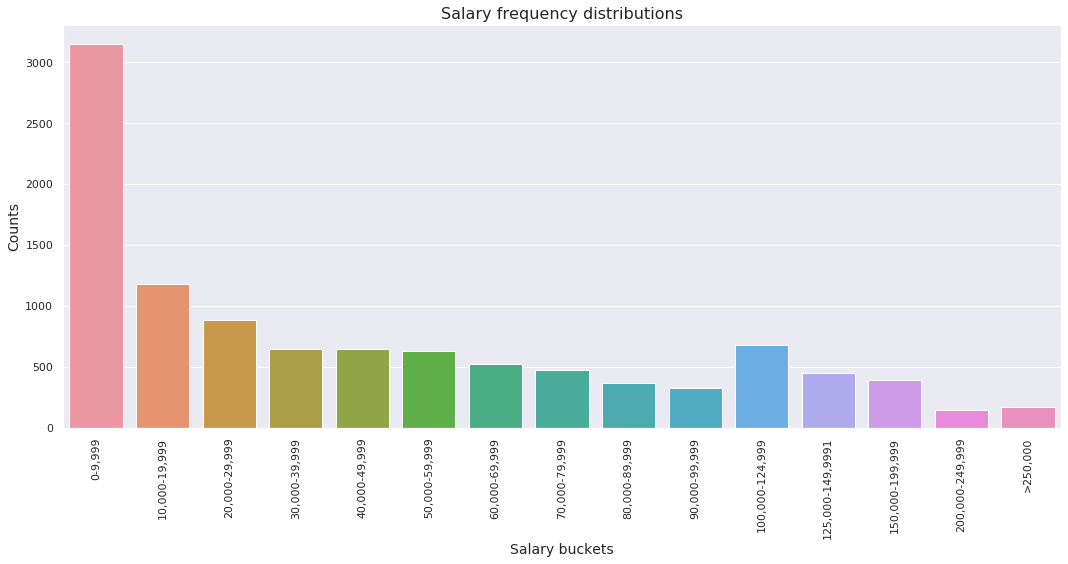

In [95]:

salary_count = df[['Q10_buckets','Q10_Encoded']].copy()
plt.figure(figsize=(15,8))
salary_dis = sns.countplot(x='Q10_buckets',data=salary_count)
salary_dis.set_xticklabels(salary_dis.get_xticklabels(), rotation=90)
salary_dis.axes.set_title('Salary frequency distributions',fontsize=16)
salary_dis.set_xlabel('Salary buckets',fontsize=14)
salary_dis.set_ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()

**Distributions vs. Countries**

There are more than 50 different countries. Most of the respondents are from America and India. These country data with onehot encoding would make the input of the model having a very high dimension, taking the model longer to solve.

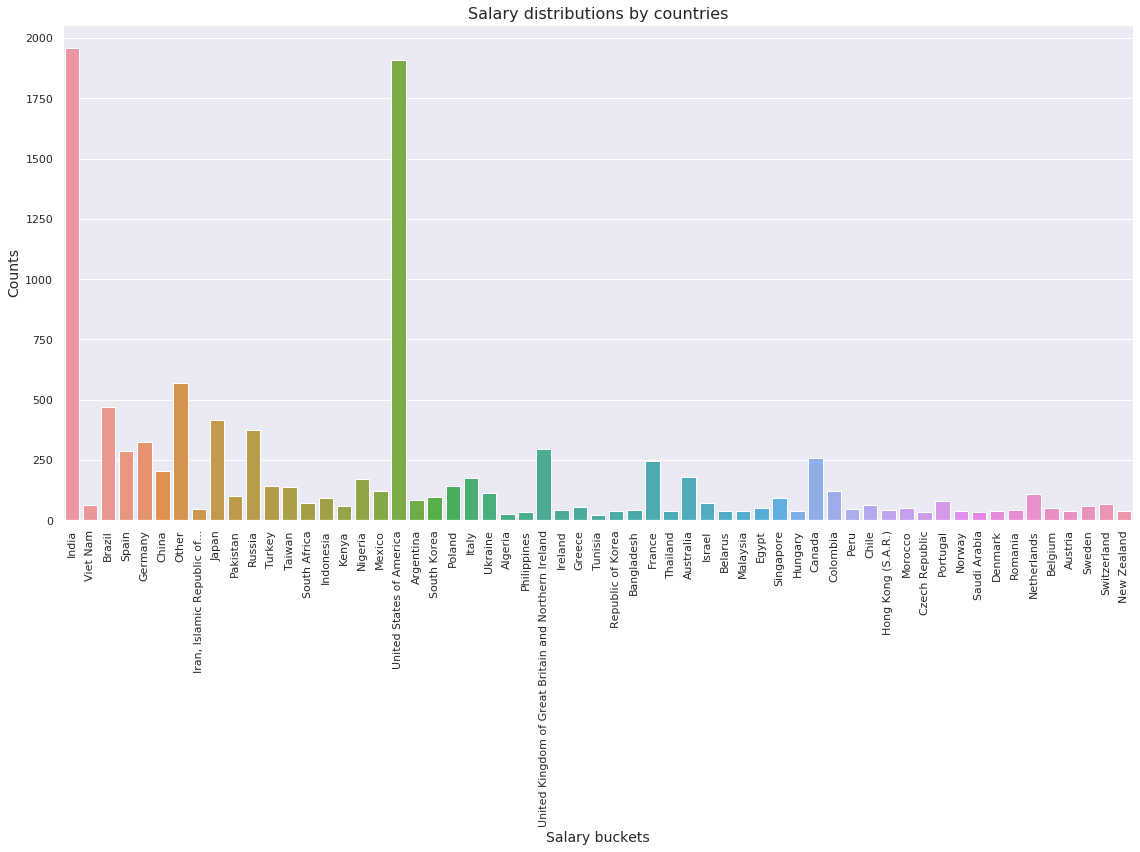

In [96]:
plt.figure(figsize=(16,12))
country_dis=sns.countplot(x='Q3',data=df)
country_dis.set_xticklabels(country_dis.get_xticklabels(), rotation=90)
country_dis.axes.set_title('Salary distributions by countries',fontsize=16)
country_dis.set_xlabel('Salary buckets',fontsize=14)
country_dis.set_ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()

**Year vs. Salary**

The two figures below show the relationships between age and salary, coding experience and salary. Salary of those under 35 or having less coding experience are at a low level. With the increase of age and working experience, people are more likely to earn a higher salary.  

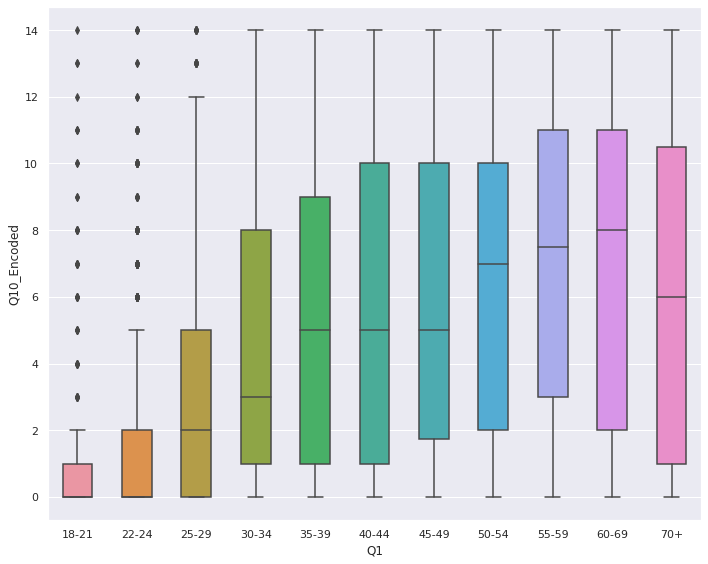

In [97]:
#Q1 What is your age?
order=["18-21", "22-24","25-29","30-34","35-39","40-44","45-49","50-54","55-59","60-69","70+"]
plt.figure(figsize=(10,8))
fig = sns.boxplot(x='Q1', y="Q10_Encoded", data=df, width=0.5, order=order)
plt.tight_layout()
plt.show()

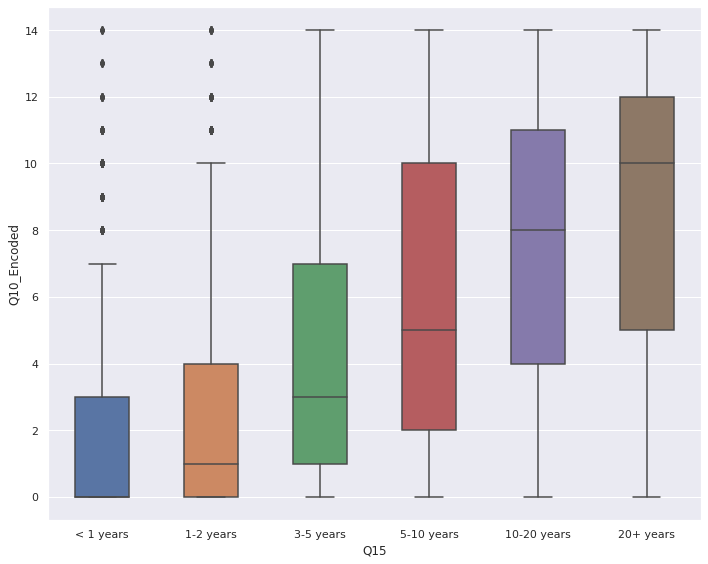

In [98]:
#Q15 How long have you been writing code to analyze data (at work or at school)?
order=['< 1 years','1-2 years','3-5 years','5-10 years','10-20 years','20+ years']
plt.figure(figsize=(10,8))
fig = sns.boxplot(x='Q15', y="Q10_Encoded", data=df, width=0.5, order=order)
plt.tight_layout()
plt.show()

**Education vs. Salary**

The figure below shows the relationship between education and salary. People with doctoral degree have the highest median and mean. However, people who choose 'No formal education past high school' or 'Some college/university study without earning a bachelor’s degree', have higher salary than people with bachelor's degree. I could not find a very clear relationship between education and salary.

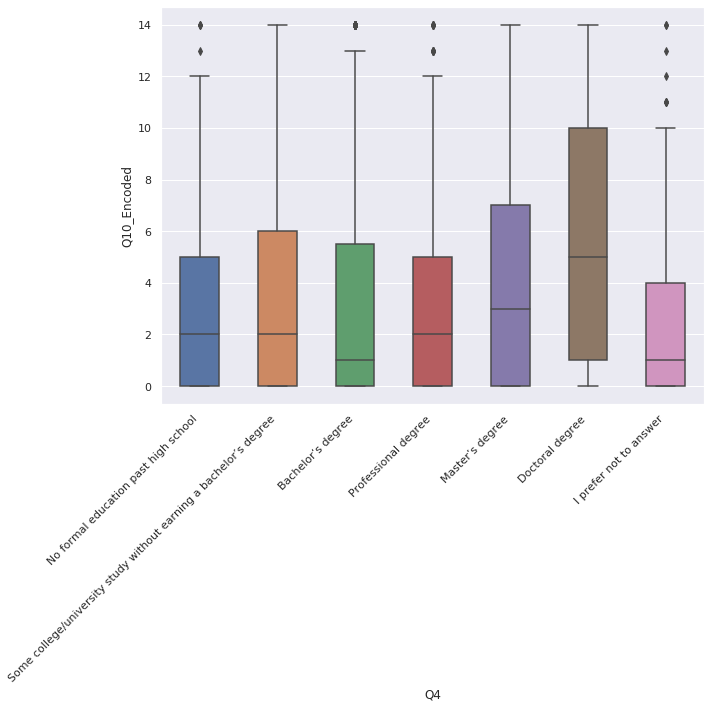

In [99]:
#Q4 Education
order=['No formal education past high school',
       'Some college/university study without earning a bachelor’s degree',
       'Bachelor’s degree',
       'Professional degree',
       'Master’s degree',
       'Doctoral degree',
       'I prefer not to answer']
plt.figure(figsize=(10,10))
fig = sns.boxplot(x='Q4', y="Q10_Encoded", data=df, width=0.5,order=order)
fig.set_xticklabels(fig.get_xticklabels(),rotation=45,ha="right")
plt.tight_layout()
plt.show()

### **2.2 Visualize the order of feature importance**

**Feature imortance in random forest**

To get the feature importance plot, wo need to know how well each feature predicts the end salary compensation. A random forest regressor model was used to extract the top 50 most important features and their respective feature imporatance score.

In [100]:
Y = df[['Q10_Encoded']]
X = df_co
forest=RandomForestRegressor(n_estimators=150, random_state=50,verbose=1,n_jobs=-1)
forest.fit(X,Y)

importances = list(forest.feature_importances_)
feature_list = list(df_co)

feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

x_feature=[]
y_importance=[]
for i in range(50):
    x_feature.append(feature_importances[i][0])
    y_importance.append(feature_importances[i][1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   54.5s finished


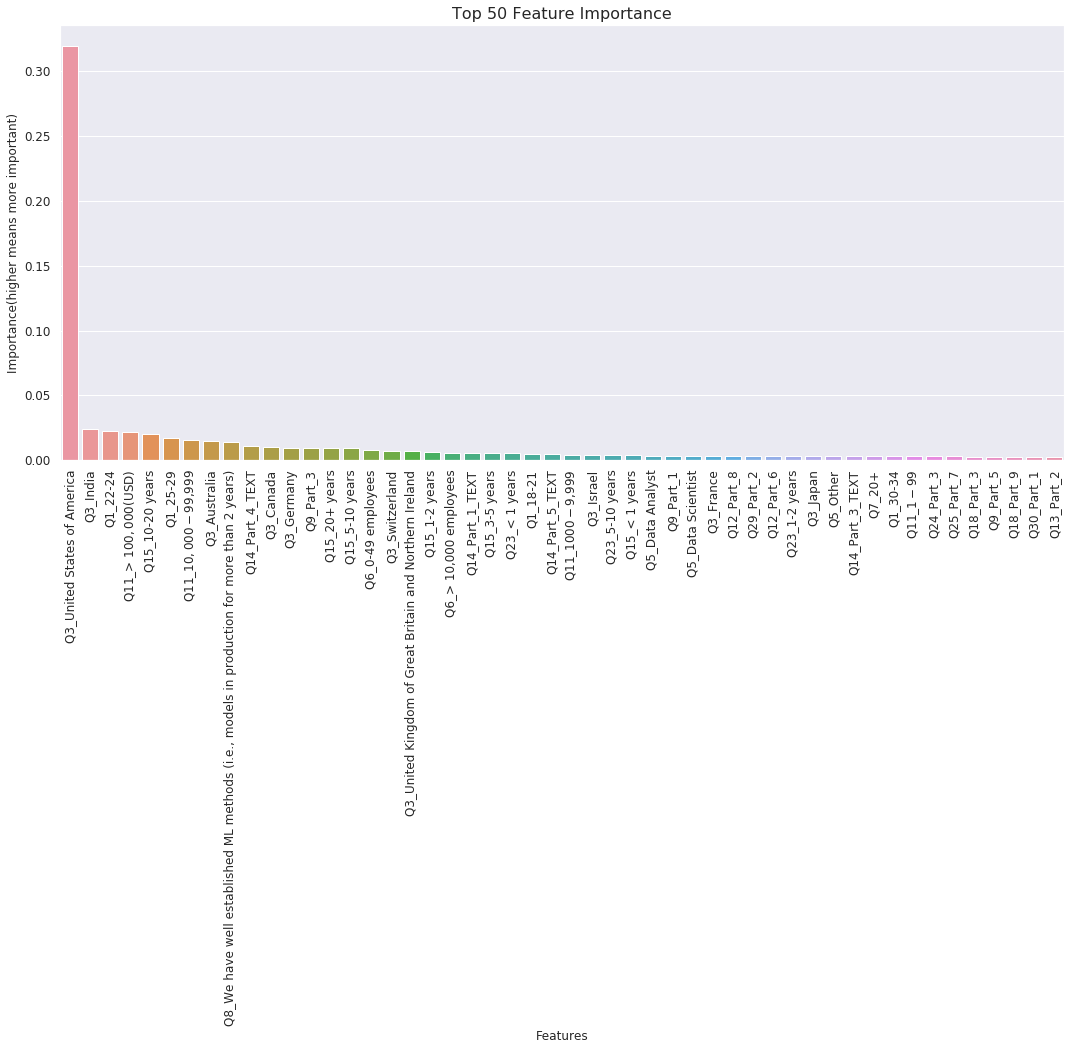

In [101]:
sns.set(rc={'figure.figsize':(18,8)})
fi=sns.barplot(x_feature, y_importance)
fi.set_xticklabels(fi.get_xticklabels(), rotation=90)
fi.axes.set_title('Top 50 Feature Importance',fontsize=16)
fi.set_xlabel('Features',fontsize=12)
fi.set_ylabel('Importance(higher means more important)',fontsize=12)
fi.tick_params(labelsize=12)

**Pearson coefficient**

Pearson coefficient was used to measure the correlation beyween each features in the dataset and the heatmap figure below shows features having high correlation with salary(Q10_Encoded).

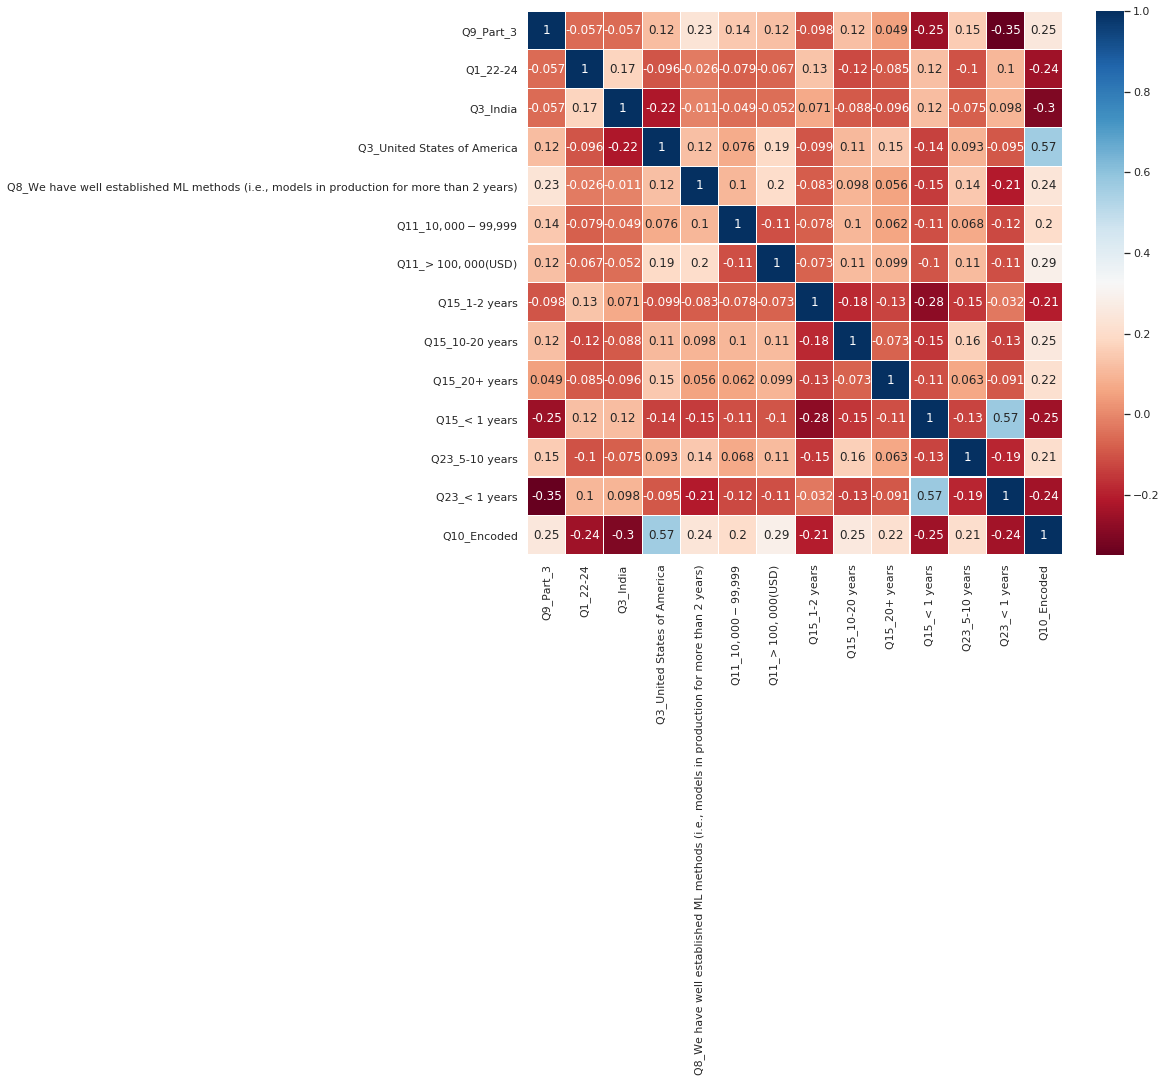

In [102]:
#Pearason corr
df_co = pd.concat([df_co, df[['Q10_Encoded']]],axis=1)
perasoncorr = df_co.corr()
corr_index = perasoncorr.index[abs(perasoncorr['Q10_Encoded'])>0.2]
plt.figure(figsize=(12,10))
sns.heatmap(df_co[corr_index].corr(), cbar=True, cmap='RdBu', annot=True,linewidth=0.1)

**Conclusions**

According to the two kinds of analysis above, we can draw a general conclusion that following attributes are the best predictor: 

    (1) Working in USA; (2) Working in India; (3) Recent money spent in ML >100K(USD); (4) Age 22-24; (5) Coding experience 10-20 years

5 most important questions in salary predictor:

    Q3: In which country do you currently reside?
    Q11: Approximately how much money have you spent on machine learning and/or cloud computing products at your work in the past 5 years?
    Q15: How long have you been writing code to analyze data (at work or at school)?
    Q23: For how many years have you used machine learning methods?
    Q9: Select any activities that make up an important part of your role at work: (Select all that apply)


# **3. Feature selection**

Feature engineering is the process of extracting features from a raw dataset, which plays an significant role in machine learning. It aims to prepare the proper input dataset, compatible with the machine learning algorithm requirements. Feature engineering helps to improve the performance of machine learning models.



**Lasso**

Lasso is a linear regression algorithm with L1 regularization, which can help us find which features have a positive or negative relationship with the salary. It uses L1 regularizer that encourages sparsity and works as a feature selector. Features with zero coefficient are moved from the dataset in this step. 

In [0]:
#Firstly, scaling the features 
scaler = ss().fit(df_co.iloc[:,:-1])
df_co.iloc[:,:-1] = scaler.transform(df_co.iloc[:,:-1])

In [104]:
#Step 1: Lasso
#choose a proper alphas
x = df_co.drop(['Q10_Encoded'], axis=1)
y = df_co['Q10_Encoded']
lasso = LassoCV(alphas = [0.01,0.05,0.1,1]).fit(x,y)
lasso.alpha_

0.01

In [105]:
#zero-coefficient features are moved
x = df_co.drop(['Q10_Encoded'], axis=1)
y = df_co['Q10_Encoded']
la = Lasso(alpha=0.01)
la.fit(x,y)
a = la.coef_.tolist()
alist=[]
for i in range(0,len(a)):
  if a[i] == 0:
    alist.append(i)

for i in df_co.iloc[:,alist].columns:
  df_co = df_co.drop([i],axis=1)

df_co.shape

(10653, 271)

**PCA**

Due to the one hot encoding in data cleaning section, the dimension of the dataset become larger. For dimensionality reduction, PCA was used in this step to select a subset of variables that preserves as much information present in the complete data as possible. 

In [106]:
#Let n_components equal to the number of features to test the appropriate value of n
pca = PCA(n_components = 270)
pca.fit_transform(df_co.iloc[:,:-1])
np.cumsum(pca.explained_variance_ratio_)


array([0.04136903, 0.0619363 , 0.08234441, 0.09790118, 0.11135199,
       0.12329898, 0.13313031, 0.14283193, 0.15193156, 0.16084279,
       0.16921655, 0.17742682, 0.18505331, 0.19252266, 0.19989309,
       0.20677021, 0.21337386, 0.21974585, 0.22597094, 0.2320521 ,
       0.23806157, 0.24400484, 0.24975211, 0.25540505, 0.26101417,
       0.2666161 , 0.27210332, 0.27754504, 0.2829599 , 0.28824451,
       0.29342966, 0.29859829, 0.30370279, 0.30877513, 0.31371738,
       0.31862808, 0.32349944, 0.32834506, 0.33314821, 0.33793512,
       0.34270321, 0.34741512, 0.3520839 , 0.35672519, 0.36131003,
       0.3658642 , 0.37036758, 0.37485271, 0.37930518, 0.38374465,
       0.3881721 , 0.39255419, 0.39693289, 0.40127129, 0.40560572,
       0.40991309, 0.41419517, 0.41847427, 0.4227211 , 0.42696183,
       0.43116762, 0.43535106, 0.43953149, 0.44369771, 0.44782212,
       0.45194032, 0.45604382, 0.46013185, 0.46420737, 0.46826831,
       0.47230696, 0.47632874, 0.48034999, 0.48436152, 0.48836

In [107]:
#For the variance ratio larger than 90%
pca = PCA(n_components = 203)
p = pca.fit_transform(df_co.iloc[:,:-1])
df_new = pd.DataFrame(p)
df_new['Q10_Encoded'] = df_co[['Q10_Encoded']].values
df_new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,Q10_Encoded
0,-5.650331,2.080228,2.548622,1.359592,-0.370142,-2.476677,0.583793,2.059456,2.537418,-0.217496,1.121729,0.680777,-2.899865,1.467353,-0.557913,-1.850180,-1.521149,-0.060461,-0.136806,-0.673891,0.509269,-1.186192,-0.232663,-0.064224,-1.457122,-0.234700,0.530434,0.651380,-0.336816,-2.222539,0.446633,1.900901,0.945337,-0.929667,-0.302706,-0.902516,-0.577543,-1.277638,1.912655,-0.645269,...,0.596490,0.060560,0.443480,-0.161480,0.370741,-0.241554,-0.324962,0.368668,0.372603,0.184605,0.392350,-0.632415,0.868946,0.949060,-0.532748,0.106860,0.712704,-0.092012,0.553716,0.921734,0.182407,0.921545,-0.292921,-0.748047,0.404532,-0.275276,0.158935,-0.453633,0.224483,-0.000466,-1.181760,0.068353,-0.623817,-0.921449,-0.109305,-0.339312,-0.931857,0.104784,0.086347,0
1,5.919674,6.860339,-1.093189,2.540856,-3.712393,-0.808032,5.908937,0.046454,-4.489727,-0.413936,-1.411325,-0.135123,-3.561320,-2.818109,1.499757,2.034259,-0.909666,-1.614012,0.983096,-0.865640,0.178789,0.642404,0.463635,1.815323,-0.460226,-2.163537,2.137005,-1.484906,-0.097165,-3.316268,-0.458362,1.139252,1.722474,-0.702065,-1.021072,-1.207515,1.449607,-1.609637,-0.110395,-1.810607,...,1.430779,-1.344032,-0.907091,0.784927,-0.544266,-0.260749,2.143227,0.440288,-0.508701,-0.711786,1.247279,-0.322841,0.520453,1.456956,-1.102535,0.412800,0.571785,-0.860725,-0.956079,0.689394,1.436344,0.443601,-0.220337,-1.750657,-0.448281,0.787699,-1.426814,-0.451703,0.493274,-0.223905,0.839229,1.446700,-2.108633,-0.636292,-1.407127,-0.702396,-0.030299,-0.177008,0.639992,0
2,2.577720,2.847424,-1.071360,-2.974481,1.952241,-0.583639,-1.101259,-0.453163,0.745944,-1.065357,0.447285,1.318214,1.029848,-0.921231,3.451540,-2.979880,-2.572725,1.337093,4.117394,-1.017503,0.189797,-3.450227,-2.830966,0.446481,-0.021754,0.664068,-1.271901,-0.279907,0.222249,-1.404157,-0.504278,1.405114,-0.367864,0.680918,2.268084,0.486142,0.154260,-0.075343,0.015829,-0.889137,...,0.732829,-0.225252,-0.156801,0.614307,-0.290849,-0.490060,1.405389,0.071611,0.876464,-0.763563,-1.391156,-0.629920,-1.747171,-1.412579,0.505598,-0.671987,-0.449184,-0.397674,0.067679,-0.819853,0.417794,-0.187307,0.711120,0.201855,1.118260,1.010446,0.787365,-0.943028,-0.693486,0.581109,-1.060786,-0.080700,0.718499,0.542742,-0.427207,-1.432472,0.338385,0.327365,-0.862861,0
3,2.664848,-0.406527,-3.906591,0.452366,0.026064,-1.098040,2.730302,0.710938,0.981147,-0.079825,-0.164100,1.633525,-0.065110,-0.258425,1.196141,-3.767658,4.339708,-0.812187,-0.124927,-1.557805,0.730756,-2.238167,0.224458,2.381850,-0.562284,2.380066,-0.169251,1.293781,0.930782,-0.445414,-1.939135,-0.193804,-0.200215,-0.011638,0.810350,1.778212,0.908874,0.118573,-1.945797,1.295347,...,-0.741223,-0.504411,0.376121,-0.010696,0.678038,0.427284,1.034089,-0.721086,-0.195533,0.269650,-0.213893,0.123374,0.088387,0.517742,-1.001887,0.681337,-0.613832,0.007804,0.205688,-0.007390,-0.589937,-0.539071,-0.437197,1.148869,-0.745433,0.720856,-0.182306,0.079788,-0.193268,0.417682,-0.288440,0.224661,0.522107,0.398963,-0.233336,-0.009795,0.750014,0.217058,0.273275,0
4,-0.944350,2.689739,-0.397787,-3.193303,0.925458,-0.600244,-2.621389,2.484877,0.179445,1.490419,-0.021439,-1.370361,-0.490210,1.994219,2.380920,-0.503072,-0.539262,1.948566,0.633688,0.562199,1.351075,1.241640,-0.981542,-1.489170,0.382627,-0.031915,3.217527,-0.407188,1.143267,-0.051395,-0.863689,-1.538543,-0.881002,0.910022,1.704367,-0.188070,-0.687780,1.089727,1.381283,-0.573063,...,0.435740,-0.587078,-0.087363,-0.984295,0.206904,0.338853,0.822783,0.425514,-0.285153,0.998531,1.671913,0.069758,0.351746,0.061931,0.489954,-0.710606,-0.349841,-0.648764,0.681820,0.405593,0.924292,0.419082,-1.330880,-0.689215,2.376167,2.319401,-1.679404,1.056793,-1.300585,0.880435,-0.8372

In [0]:
#Current Number of Data: 10653
#Current Number of Feature: 203

# **4. Model implementation**

Implement ordinal logistic regression algorithm on the training data using 10-fold cross-validation. 

In [0]:
X = df_new.drop(['Q10_Encoded'], axis=1)
Y = df_new['Q10_Encoded']

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.3, random_state=10)

In [0]:
def kfold(model):
    kf = KFold(n_splits=10)
    X = X_Train
    Y = Y_Train
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        x_train, x_test = X.values[train_index], X.values[test_index]
        y_train, y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    ave = np.mean(outcomes)
    var = np.var(outcomes)
    print("Average of accuracy: {0}".format(ave)) 
    print("Variance of accuracy: {0}".format(var))

In [0]:
class Ord():
 
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


In [112]:
OrdLor = Ord(LogisticRegression(penalty='l2',max_iter=500,multi_class='ovr'))
kfold(OrdLor)

Fold 1 accuracy: 0.34584450402144773
Fold 2 accuracy: 0.3485254691689008
Fold 3 accuracy: 0.3324396782841823
Fold 4 accuracy: 0.3512064343163539
Fold 5 accuracy: 0.33646112600536193
Fold 6 accuracy: 0.339142091152815
Fold 7 accuracy: 0.3445040214477212
Fold 8 accuracy: 0.32483221476510066
Fold 9 accuracy: 0.33422818791946307
Fold 10 accuracy: 0.3624161073825503
Average of accuracy: 0.3419599834463897
Variance of accuracy: 0.00010505723749914254


The average accuracy of the model with default parameters is 34.4% and the variance is 0.0133%.



To optimize the model, we're going to treat each value of hyperparameters as a new model. There are 25 kinds of combinations for hyperparameters c in [0.001, 0.005, 0.01, 0.025, 0.05] and solver types in ['lbfgs', 'sag', 'liblinear', 'newton-cg', 'saga'].

In [0]:

ave_results = []
var_results = []
c_3 = []
c_4 = []
for i in [0.001, 0.005, 0.01, 0.025, 0.05]:
  for j in range(5):
    solver_types = ['lbfgs', 'sag', 'liblinear', 'newton-cg', 'saga']
    lor = LogisticRegression(penalty='l2', C=i, solver=solver_types[j],max_iter=500,multi_class='ovr')
    OrdLor = Ord(lor)
    print('--------------------------\n C = ' + str(i) + '; solver = ' + str(solver_types[j]))
  
    #kfold
    kf = KFold(n_splits=10)
    X = X_Train
    Y = Y_Train
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        x_train, x_test = X.values[train_index], X.values[test_index]
        y_train, y_test = Y.values[train_index], Y.values[test_index]
        
        OrdLor.fit(x_train, y_train)
        predictions = OrdLor.predict(x_test)
        
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        
    ave = np.mean(outcomes)
    var = np.var(outcomes)
    print("Average of accuracy: {0}".format(ave)) 
    print("Variance of accuracy: {0}".format(var))
    ave_results.append(ave)
    var_results.append(var)
    c_3.append(i)
    c_4.append(solver_types[j])
  

--------------------------
 C = 0.001; solver = lbfgs
Average of accuracy: 0.34571963222196234
Variance of accuracy: 0.0001369423217093823
--------------------------
 C = 0.001; solver = sag
Average of accuracy: 0.34585368047933496
Variance of accuracy: 0.00013462186887870583
--------------------------
 C = 0.001; solver = liblinear
Average of accuracy: 0.29381884592547275
Variance of accuracy: 0.0003365076963445212
--------------------------
 C = 0.001; solver = newton-cg


In [0]:
result = pd.DataFrame()
result['Average of accuracy'] = ave_results
result['Variance of accuracy'] = var_results
result['C value'] = c_3
result['Solver type'] = c_4 
result['error_score'] = c_4
#bias-variance trade-off
#error_score = bias^2 + variance
for i in range(25):
  result.iloc[i,4] = (1 - result.iloc[i,0])**2 + result.iloc[i,1]
result.sort_values(by='error_score')

According to the dataframe above, when C=0.05, the model got relatively low error. To select a final optimal model, we're going to treat the model for hyperparameters c in [0.0025, 0.005, 0.0075] and solver types in ['lbfgs', 'sag', 'liblinear', 'newton-cg', 'saga']. Then also use the bias-var trade-off method to measure the model performance.

# **5. Model tunning**

In [0]:
ave_results = []
var_results = []
c_3 = []
c_4 = []
for i in [0.0025, 0.005, 0.0075]:
  for j in range(5):
    solver_types = ['lbfgs', 'sag', 'liblinear', 'newton-cg', 'saga']
    lor = LogisticRegression(penalty='l2', C=i, solver=solver_types[j],max_iter=500,multi_class='ovr')
    OrdLor = Ord(lor)
    print('--------------------------\n C = ' + str(i) + '; solver = ' + str(solver_types[j]))
  
    #kfold
    kf = KFold(n_splits=10)
    X = X_Train
    Y = Y_Train
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        x_train, x_test = X.values[train_index], X.values[test_index]
        y_train, y_test = Y.values[train_index], Y.values[test_index]
        
        OrdLor.fit(x_train, y_train)
        predictions = OrdLor.predict(x_test)
        
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        
    ave = np.mean(outcomes)
    var = np.var(outcomes)
    print("Average of accuracy: {0}".format(ave)) 
    print("Variance of accuracy: {0}".format(var))
    ave_results.append(ave)
    var_results.append(var)
    c_3.append(i)
    c_4.append(solver_types[j])
  

In [0]:
result = pd.DataFrame()
result['Average of accuracy'] = ave_results
result['Variance of accuracy'] = var_results
result['C value'] = c_3
result['Solver type'] = c_4 
result['error_score'] = c_4
#bias-variance trade-off
#error_score = bias^2 + variance
for i in range(15):
  result.iloc[i,4] = (1 - result.iloc[i,0])**2 + result.iloc[i,1]
result.sort_values(by='error_score')

After this further optimization, the overall error score decreased, and the best model performs 35.36% accuracy and very low accuracy variance. 


Now we have decided the final optimal model! The hyperparameters are C = 0.0025 and solver = 'saga'.

Next we're going to use this model to make classifications on the test set.

# **6. Testing & Discussion**

### **6.1 Testing result**

Use the final optimal model in testing dataset.

In [0]:
OrdLor = Ord(LogisticRegression(penalty='l2',max_iter=500,multi_class='ovr',C=0.0025 ,solver='saga'))
OrdLor.fit(X_Train, Y_Train)
predictions = OrdLor.predict(X_Test)
accuracy = accuracy_score(Y_Test, predictions)

print("Testing accuracy: " + str(accuracy))

Plot the salary distribution.

In [0]:
plot_result = pd.DataFrame(Y_Test)
plot_result['pred'] = predictions
plot_result.columns=['actual','pred']

In [0]:
font_size=8
label_size=6
sns.distplot(plot_result['pred'], bins=15,  color="red",label='Predicted Salary')
ax=sns.distplot(plot_result['actual'], bins=15, color="skyblue",label='Actual Salary')
plt.legend()
ax.axes.set_title('Prediction vs Truth Histogram',fontsize=font_size+5);
ax.set_xlabel('Salary',fontsize=font_size+5);
ax.set_ylabel('Distributions',fontsize=font_size+5);

### **6.2 Discussion**

The distribution histogram above visualized the testing result. The red columns represent predicted salary value while the blue columns represent the true value. It is obviously showed in the graph that the predicted value is much higher than the true value for those salary in 0(0-9999USD) and 10(100,000-124,999USD). For target 0, prediction number is much larger(Nearly twice) than the truth, and this target has the largest data sample size, so the model's over predicting in this target has nonnegligible effect on accuracy. 

The training accuracy is 35.36% while the testing accuracy is 35.70%. Comparing the model performances in training and testing data, their accuaracys are very close, due to the 10-fold cross-validation on training dataset which effectively reduced overfitting. 

However, both training and testing accuracy are low, showing the model is not doing good, and the reason may be complicated. Below listed two potential causes and corresponding solutions.

**Reason 1 and its solution:**
*  I think one of the most important reason is my data cleaning procession still needs to be improved. I used one hot encoding for all the single-answer questions, for example, the age and the working experience features, these features have the categories with general rank for salary prediction (people earn higher salary with increasing age and working experience). 
*  It may be better to treat these features using ordinal data encoding.

**Reason 2 and its solution:**
*  Facing an imbalanced classes may be another important reason. The dataset has more than 3000 sample targeted 0 while only less than 200 samples are targeted 14. There isn't enough data on the salaries that have a very high salary number, thus the model could not get enough impute to properly fit those high salary points. So we get our best classifier a “naive” one that always answer the majority class, which also explains the over predicting in target 0. 
*  We can do oversampling for the minority class and undersampling for the majority class. Then we will get an equal ratio of data points for each class.